# Iowa Liquor Sales Analysis_Model
This data is available from https://data.iowa.gov/api/views/m3tr-qhgy/rows.csv?accessType=DOWNLOAD.

--Jie Cui

## Setup & Imports

In [0]:
# Common imports
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os

# Plotting imports and settings
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (13,8)

In [0]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = "."

imgpath = os.path.join(PROJECT_ROOT_DIR, "images")
if not os.path.exists(imgpath):
    os.makedirs(imgpath)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [0]:
# Volume Sold & Time
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# IowaSales_Copy_Filled
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
# LSTM neural network training related parameters 
past_history = 360
future_target = 60
n_neurons = [32, 16]
STEP = 6
BATCH_SIZE = 256
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 200 # Not to big to avoid too slow
EPOCHS = 10

## Load

In [0]:
isLocal = True

filename = "IowaSales_Copy_Filled_BeforeDrop.csv"
google_drv_path = "/content/drive/My Drive/TestingData/"
local_path = "../../DataSets/Iowa/"
if not isLocal: 
  !pip install -U -q PyDrive
  from google.colab import drive
  drive.mount("/content/drive", force_remount=True)
  full_filepath = google_drv_path + filename
else:
  full_filepath = local_path + filename 

In [0]:
%%time
IowaSales = pd.read_csv(full_filepath, low_memory=False, parse_dates=True)
IowaSales.shape

Wall time: 41.8 s


(18066909, 21)

In [0]:
size = IowaSales.shape[0]
if(pd.options.display.max_info_rows <= size):
  pd.options.display.max_info_rows = size + 1
pd.options.display.max_rows = 500
print(pd.options.display.max_info_rows)

18066910


In [0]:
IowaSales['Date'] = pd.to_datetime(IowaSales['Date'])
IowaSales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18066909 entries, 0 to 18066908
Data columns (total 21 columns):
 #   Column                 Non-Null Count     Dtype         
---  ------                 --------------     -----         
 0   Date                   18066909 non-null  datetime64[ns]
 1   Store Number           18066909 non-null  int64         
 2   City                   18066909 non-null  object        
 3   Zip Code               18066909 non-null  int64         
 4   County Number          18066909 non-null  float64       
 5   Category               18066909 non-null  float64       
 6   Category Name          18066909 non-null  object        
 7   Vendor Number          18066909 non-null  float64       
 8   Item Number            18066909 non-null  int64         
 9   Pack                   18066909 non-null  int64         
 10  Bottle Volume (ml)     18066909 non-null  int64         
 11  State Bottle Cost      18066909 non-null  float64       
 12  State Bottle

In [0]:
IowaSales.head()

,Date,Store Number,City,Zip Code,County Number,Category,Category Name,Vendor Number,Item Number,Pack,...,State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Longtidute,Latitude,Month,Pack Volume (ml)
0,2017-06-21,2642,PELLA,50219,63.0,1081500.0,CORDIALS & LIQUEURS,65.0,86112,12,...,2.33,3.50,12,42.00,12.0,3.17,-92.899277,41.396961,6,12000
1,2017-06-21,5050,CARLISLE,50047,91.0,1081400.0,SCHNAPPS,55.0,84172,10,...,6.00,9.00,1,9.00,0.6,0.16,-93.499634,41.497945,6,6000
2,2017-06-22,4598,DES MOINES,50317,77.0,1031200.0,VODKA,205.0,40593,24,...,3.50,5.25,4,21.00,1.5,0.40,-93.577655,41.627702,6,9000
3,2017-06-22,3645,WINDSOR HEIGHTS,50311,77.0,1062200.0,RUM,434.0,45278,6,...,7.84,11.76,6,70.56,10.5,2.77,-93.716991,41.594787,6,10500
4,2017-06-22,2854,URBANDALE,50323,77.0,1071100.0,COCKTAIL,65.0,63355,12,...,6.29,9.44,6,56.64,4.5,1.19,-93.814927,41.614948,6,9000


In [0]:
# One Hot encoder - converting 
IowaSales_Copy = pd.get_dummies(IowaSales, columns=["Category Name"], prefix_sep='_', drop_first=True)
IowaSales_Copy = pd.get_dummies(IowaSales_Copy, columns=["County Number"], prefix_sep='_', drop_first=True)


In [0]:
IowaSales_Reduced = IowaSales_Copy.drop(
    ['City', 'Category', 'Zip Code', 'Vendor Number', 'Store Number', 'Item Number', 'Volume Sold (Gallons)', 'State Bottle Retail', 'Longtidute'], 
    axis=1)

In [0]:
IowaSales_Reduced.columns[:].to_list()

['Date',
 'Pack',
 'Bottle Volume (ml)',
 'State Bottle Cost',
 'Bottles Sold',
 'Sale (Dollars)',
 'Volume Sold (Liters)',
 'Latitude',
 'Month',
 'Pack Volume (ml)',
 'Category Name_ANISETTE',
 'Category Name_BEER',
 'Category Name_BRANDIES',
 'Category Name_COCKTAIL',
 'Category Name_CORDIALS & LIQUEURS',
 'Category Name_GINS',
 'Category Name_IOWA DISTILLERIES',
 'Category Name_MEZCAL',
 'Category Name_OTHERS',
 'Category Name_ROCK & RYE',
 'Category Name_RUM',
 'Category Name_SCHNAPPS',
 'Category Name_SCOTCH',
 'Category Name_SPECIAL ORDER ITEMS',
 'Category Name_SPIRIT SPECIALTY',
 'Category Name_TEQUILA',
 'Category Name_VODKA',
 'Category Name_WHISKY',
 'County Number_2.0',
 'County Number_3.0',
 'County Number_4.0',
 'County Number_5.0',
 'County Number_6.0',
 'County Number_7.0',
 'County Number_8.0',
 'County Number_9.0',
 'County Number_10.0',
 'County Number_11.0',
 'County Number_12.0',
 'County Number_13.0',
 'County Number_14.0',
 'County Number_15.0',
 'County Number_

In [0]:
from sklearn.model_selection import train_test_split
IowaSales_Main = IowaSales_Copy.copy()
# y_Sale = IowaSales_Main[['Sale (Dollars)']].values
# X_Sale = IowaSales_Main.drop(['Sale (Dollars)', 'City'], axis=1).values
# X_Sale_train, X_Sale_test, y_Sale_train, y_Sale_test = train_test_split(X_Sale, y_Sale)

Saving figure attribute_histogram_plots_filled


<ipython-input-2-6482fb7b55fe>:13: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


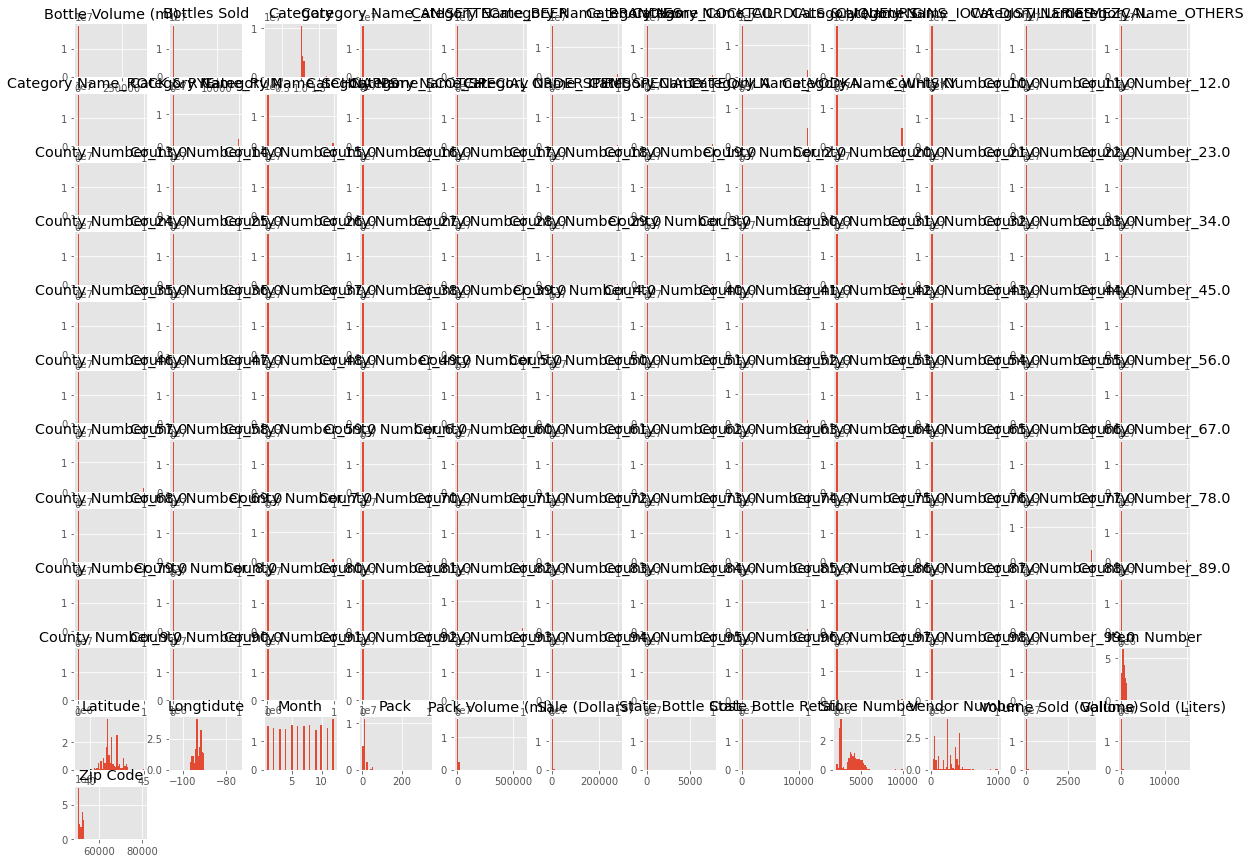

In [0]:
# %matplotlib inline
# import matplotlib.pyplot as plt
IowaSales_Main.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots_filled")
plt.show()

## Model

Build the ML models and fit them to the dataset.

We are going to use the **LSTM** (Long Short-Term memory) model as this model will detect both long-term and short-term dependencies in the data, while other models more consider short term and more likely to lose some long-term memory  or information. Base on the inspection of the data, we might consider a little bit more of long-term dependencies. 

In [0]:
IowaSales_Reduced.head()

,Date,Pack,Bottle Volume (ml),State Bottle Cost,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Latitude,Month,Pack Volume (ml),...,County Number_90.0,County Number_91.0,County Number_92.0,County Number_93.0,County Number_94.0,County Number_95.0,County Number_96.0,County Number_97.0,County Number_98.0,County Number_99.0
0,2017-06-21,12,1000,2.33,12,42.00,12.0,41.396961,6,12000,...,0,0,0,0,0,0,0,0,0,0
1,2017-06-21,10,600,6.00,1,9.00,0.6,41.497945,6,6000,...,0,1,0,0,0,0,0,0,0,0
2,2017-06-22,24,375,3.50,4,21.00,1.5,41.627702,6,9000,...,0,0,0,0,0,0,0,0,0,0
3,2017-06-22,6,1750,7.84,6,70.56,10.5,41.594787,6,10500,...,0,0,0,0,0,0,0,0,0,0
4,2017-06-22,12,750,6.29,6,56.64,4.5,41.614948,6,9000,...,0,0,0,0,0,0,0,0,0,0


In [0]:
IowaSales_Resampled = IowaSales_Reduced.resample('W-Mon', on='Date').sum().reset_index().sort_values(by='Date')

In [0]:
IowaSales_Resampled_ByDay = IowaSales_Reduced.resample('1D', on='Date').sum().reset_index().sort_values(by='Date')

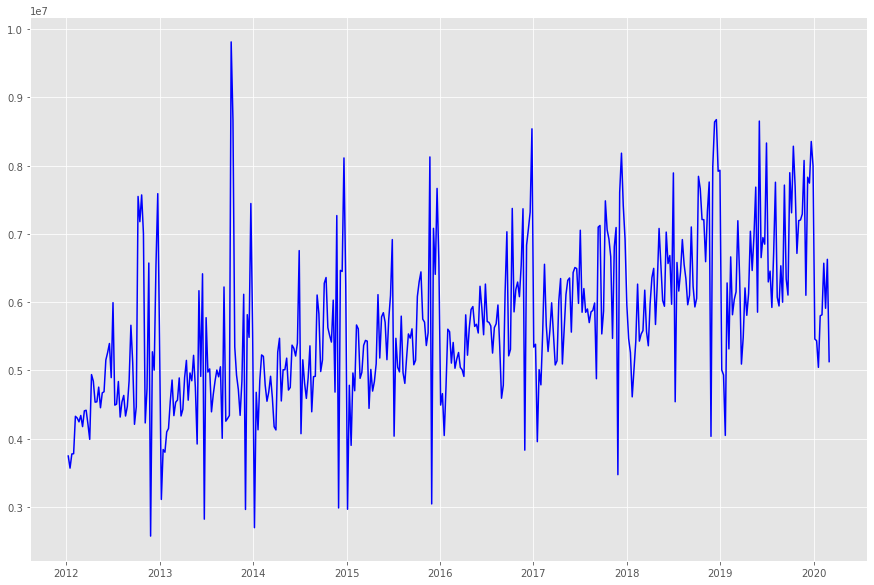

In [0]:
# inspect there's any trend of the sales total during these years.
plt.figure(figsize=(15,10))
plt.plot(IowaSales_Resampled["Date"], IowaSales_Resampled["Sale (Dollars)"], color='blue')

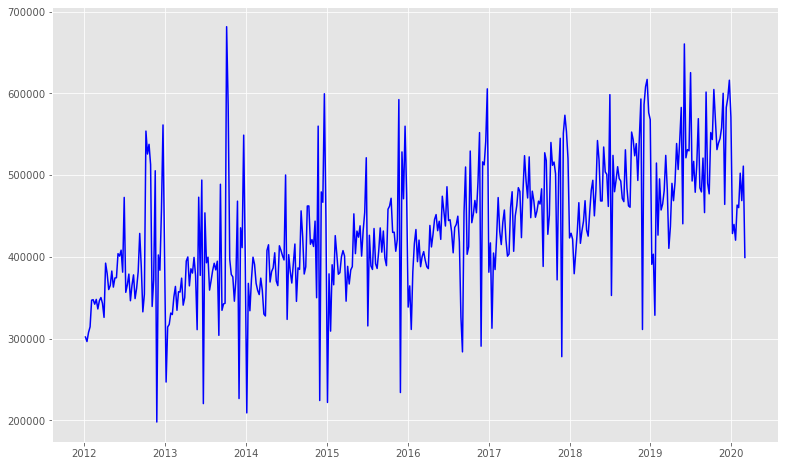

In [0]:
# Inspect if there's any trend of "bottles Sold" during these years.
plt.plot(IowaSales_Resampled["Date"], IowaSales_Resampled["Bottles Sold"], color='blue')

In [0]:
# generate the rolling of total sale and smooth the curve.
window = 14
rolling_sum = IowaSales_Resampled_ByDay["Sale (Dollars)"].rolling(window).sum()
rolling_avg = (rolling_sum / window)[window-1:]
IowaSales_Resampled_WithRollAvg = IowaSales_Resampled_ByDay[window:]
IowaSales_Resampled_WithRollAvg["Sale-14 Days (Dollars)"] = rolling_avg[:]

<ipython-input-22-95eba08fbbf0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IowaSales_Resampled_WithRollAvg["Sale-14 Days (Dollars)"] = rolling_avg[:]


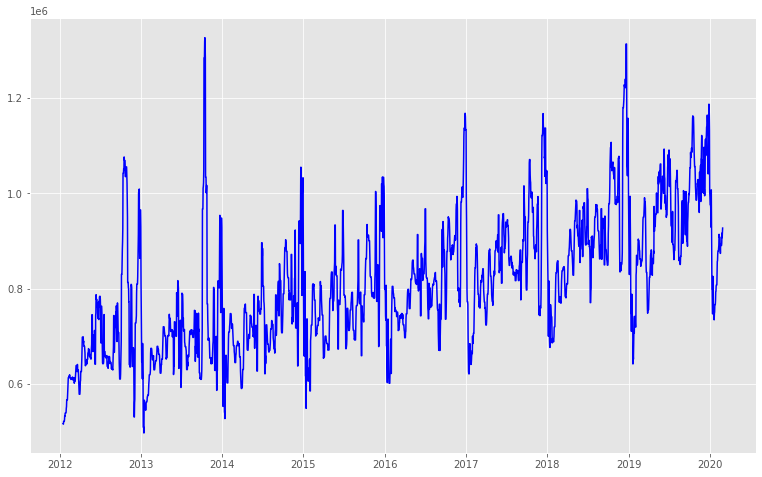

In [0]:
plt.plot(IowaSales_Resampled_WithRollAvg["Date"], IowaSales_Resampled_WithRollAvg["Sale-14 Days (Dollars)"], color='blue')

In [0]:
IowaSales_Resampled.shape, IowaSales_Resampled_ByDay.shape, IowaSales_Resampled_WithRollAvg.shape
# plt.figure(figsize=(15,10))
# sns.heatmap(IowaSales_Reduced.iloc[:, 1:].corr(), center=0);

((426, 126), (2979, 126), (2965, 127))

In [0]:
IowaSales_Resampled_WithRollAvg.head(8)

,Date,Pack,Bottle Volume (ml),State Bottle Cost,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Latitude,Month,Pack Volume (ml),...,County Number_91.0,County Number_92.0,County Number_93.0,County Number_94.0,County Number_95.0,County Number_96.0,County Number_97.0,County Number_98.0,County Number_99.0,Sale-14 Days (Dollars)
14,2012-01-17,109535,8676175,79027.73,74003,920349.50,72333.12,376027.573953,8987,85491150,...,197.0,9.0,0.0,0.0,70.0,0.0,0.0,0.0,47.0,515760.633571
15,2012-01-18,92592,7414828,68031.26,67677,849575.20,67213.16,321815.221052,7672,72530794,...,19.0,139.0,0.0,389.0,0.0,0.0,160.0,0.0,75.0,515012.167143
16,2012-01-19,111315,7795878,75325.96,86150,1021175.90,76553.93,361534.295803,8654,79253280,...,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,520796.522143
17,2012-01-20,0,0,0.00,0,0.00,0.00,0.000000,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,520796.522143
18,2012-01-21,0,0,0.00,0,0.00,0.00,0.000000,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,520796.522143
19,2012-01-22,0,0,0.00,0,0.00,0.00,0.000000,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,520796.522143
20,2012-01-23,95173,7816202,73229.22,79689,984127.78,73212.79,340330.651066,8042,76472020,...,0.0,0.0,59.0,29.0,29.0,181.0,744.0,32.0,29.0,524496.980714
21,2012-01-24,108699,8986603,81794.47,80642,1012335.19,80299.11,383920.429064,9171,87618560,...,172.0,8.0,0.0,0.0,81.0,0.0,0.0,0.0,46.0,532568.670000


In [0]:
# Remove dummy data - whole row with 0
# IowaSales_Cleaned = IowaSales_Resampled_ByDay[IowaSales_Resampled_ByDay['Pack'] > 0]
IowaSales_Cleaned = IowaSales_Resampled_WithRollAvg.drop(['Sale (Dollars)'], axis=1)
IowaSales_Cleaned.shape

(2965, 126)

In [0]:
# 80~20 - training set splitting.
TRAIN_SPLIT = int(len(IowaSales_Cleaned) * 0.8)
TRAIN_SPLIT

2372

In [0]:
# Codes referred from: https://www.tensorflow.org/tutorials/structured_data/time_series
# The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step):
    data = []
    labels = []

    start_index = (start_index + history_size) if start_index < history_size else start_index
    if end_index is None:
        end_index = len(dataset) - target_size
   
    for i in range(start_index, end_index):
        if ((i + step) >= end_index or i >= end_index): 
            break
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [0]:
# standardize the dataset using the mean and standard deviation of the given data.
def standardize(dataset, training_size):
    data_mean = dataset[:training_size].mean(axis=0)
    data_std = dataset[:training_size].std(axis=0)
    dataset_standardized = (dataset-data_mean)/data_std
    return dataset_standardized, data_mean, data_std

In [0]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [0]:
def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction, mean, std):
    plt.figure(figsize=(12, 6))
    
    num_in = create_time_steps(len(history))    
    num_out = len(true_future)

    hist_pos = history.shape[1] - 1;    
    invert_history = history * std + mean    
    
    plt.plot(num_in, np.array(invert_history[:, hist_pos]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'b-', label='True Future')

    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'r--', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [0]:
def setup_model(X, target_size, n_neurons): 

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(n_neurons[0], return_sequences=True, input_shape=X.shape[-2:]))
    model.add(tf.keras.layers.LSTM(n_neurons[1], activation='relu'))
    model.add(tf.keras.layers.Dense(target_size))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
    
    return model

# LSTM Neural Network #

In [0]:
y_data = IowaSales_Cleaned["Sale-14 Days (Dollars)"].values
X_data = IowaSales_Cleaned.drop(['Date'], axis=1).values
X_data_norm, X_data_mean, X_data_std = standardize(X_data, TRAIN_SPLIT)

In [0]:
X_data.shape, IowaSales_Cleaned.shape, IowaSales_Cleaned.columns[:].to_list()

((2965, 125),
 (2965, 126),
 ['Date',
  'Pack',
  'Bottle Volume (ml)',
  'State Bottle Cost',
  'Bottles Sold',
  'Volume Sold (Liters)',
  'Latitude',
  'Month',
  'Pack Volume (ml)',
  'Category Name_ANISETTE',
  'Category Name_BEER',
  'Category Name_BRANDIES',
  'Category Name_COCKTAIL',
  'Category Name_CORDIALS & LIQUEURS',
  'Category Name_GINS',
  'Category Name_IOWA DISTILLERIES',
  'Category Name_MEZCAL',
  'Category Name_OTHERS',
  'Category Name_ROCK & RYE',
  'Category Name_RUM',
  'Category Name_SCHNAPPS',
  'Category Name_SCOTCH',
  'Category Name_SPECIAL ORDER ITEMS',
  'Category Name_SPIRIT SPECIALTY',
  'Category Name_TEQUILA',
  'Category Name_VODKA',
  'Category Name_WHISKY',
  'County Number_2.0',
  'County Number_3.0',
  'County Number_4.0',
  'County Number_5.0',
  'County Number_6.0',
  'County Number_7.0',
  'County Number_8.0',
  'County Number_9.0',
  'County Number_10.0',
  'County Number_11.0',
  'County Number_12.0',
  'County Number_13.0',
  'County Numb

In [0]:
X_train, y_train = multivariate_data(X_data_norm, y_data, 0,
                                     TRAIN_SPLIT, past_history,
                                     future_target, STEP)
X_val, y_val = multivariate_data(X_data_norm, y_data,
                                 TRAIN_SPLIT, None, past_history,
                                 future_target, STEP)

In [0]:
print ('Single window of past history : {}'.format(X_train[0].shape))
print ('\n Target to predict : {}'.format(y_train[0].shape))

Single window of past history : (60, 125)

 Target to predict : (60,)


In [0]:
train_data_slices = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data_slices = train_data_slices.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_slices = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_data_slices = val_data_slices.batch(BATCH_SIZE).repeat()

In [0]:
train_data_slices,val_data_slices,X_val.shape

(<RepeatDataset shapes: ((None, 60, 125), (None, 60)), types: (tf.float64, tf.float64)>,
 <RepeatDataset shapes: ((None, 60, 125), (None, 60)), types: (tf.float64, tf.float64)>,
 (527, 60, 125))

In [0]:
lstm = setup_model(X_train, future_target, n_neurons)

In [0]:
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 32)            20224     
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                1020      
Total params: 24,380
Trainable params: 24,380
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Quick look of the output structure
for x, y in val_data_slices.take(1):
    print('1', lstm.predict(x).shape)


1 (256, 60)


In [0]:
multi_out = lstm.fit(train_data_slices, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_data_slices,
                      validation_steps=50)

Epoch 1/10
200/200 [==============================] - 25s 124ms/step - loss: 22645410.0000 - val_loss: 241269.7812
Epoch 2/10
200/200 [==============================] - 27s 133ms/step - loss: 3860121.2500 - val_loss: 156002.2656
Epoch 3/10
200/200 [==============================] - 25s 124ms/step - loss: 138100.7031 - val_loss: 123364.3594
Epoch 4/10
200/200 [==============================] - 24s 120ms/step - loss: 131167.1562 - val_loss: 117873.4375
Epoch 5/10
200/200 [==============================] - 25s 125ms/step - loss: 129471.5703 - val_loss: 116028.0312
Epoch 6/10
200/200 [==============================] - 24s 121ms/step - loss: 128477.0469 - val_loss: 115953.2109
Epoch 7/10
200/200 [==============================] - 24s 119ms/step - loss: 127313.2891 - val_loss: 115022.1562
Epoch 8/10
200/200 [==============================] - 24s 119ms/step - loss: 126326.7891 - val_loss: 113115.0234
Epoch 9/10
200/200 [==============================] - 24s 120ms/step - loss: 125876.4062 - va

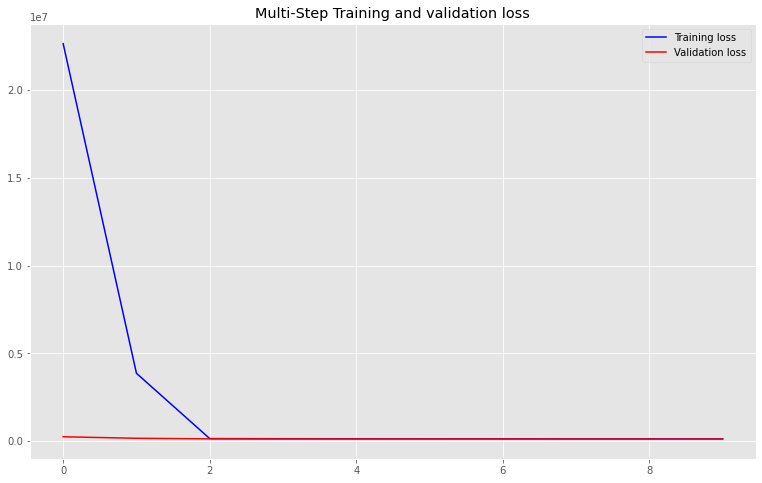

In [0]:
plot_train_history(multi_out, 'Multi-Step Training and validation loss')

It seems that the gap of Training loss and Validation loss is getting smaller and finally almost converge, which means the performance on validation dataset is reasonable.

In [0]:
X_data.shape

(2965, 125)

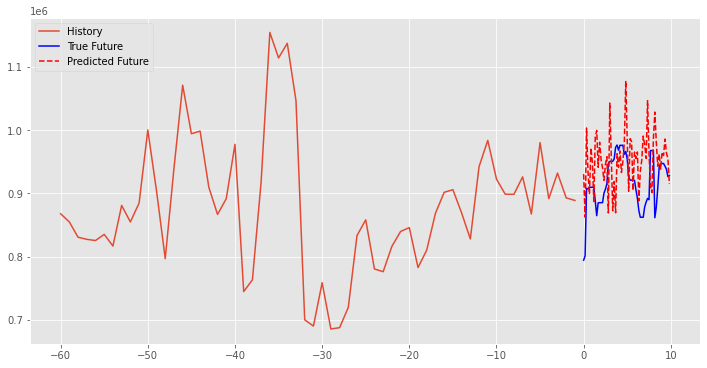

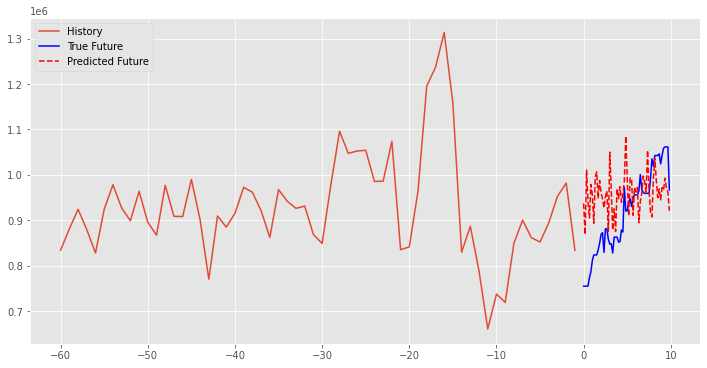

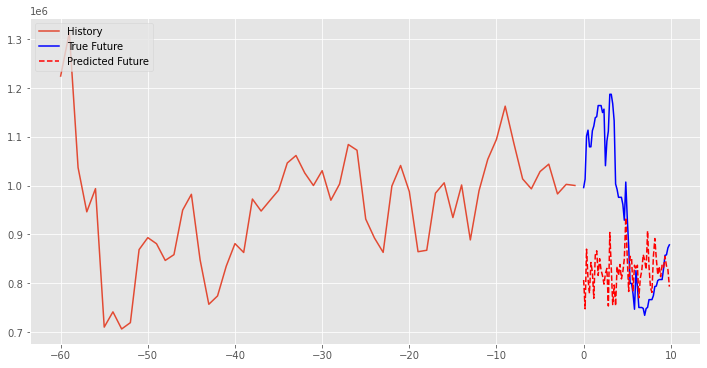

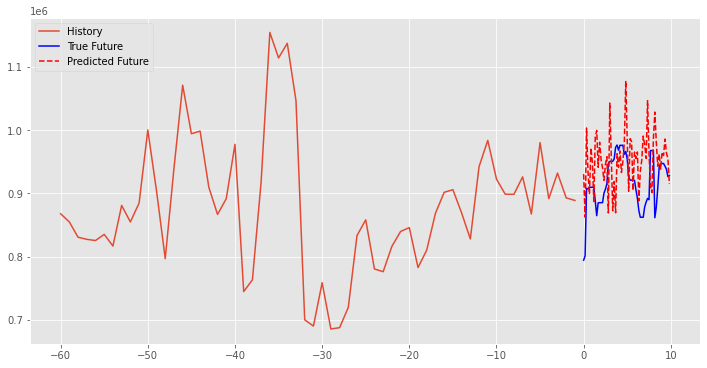

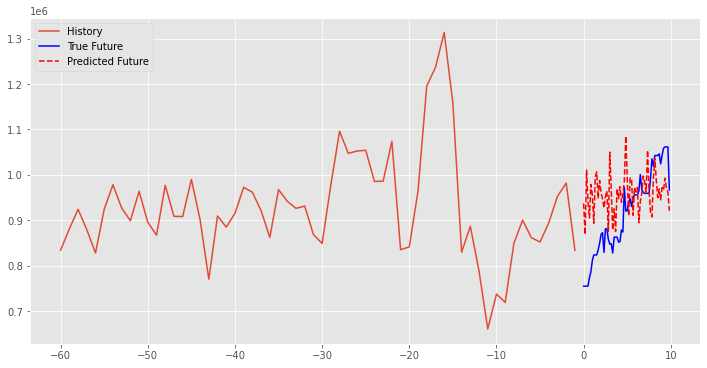

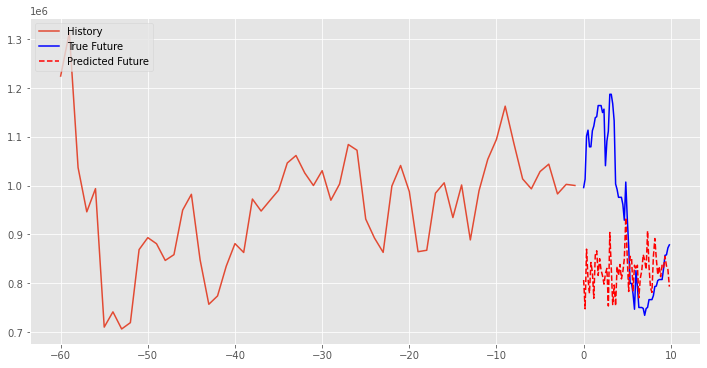

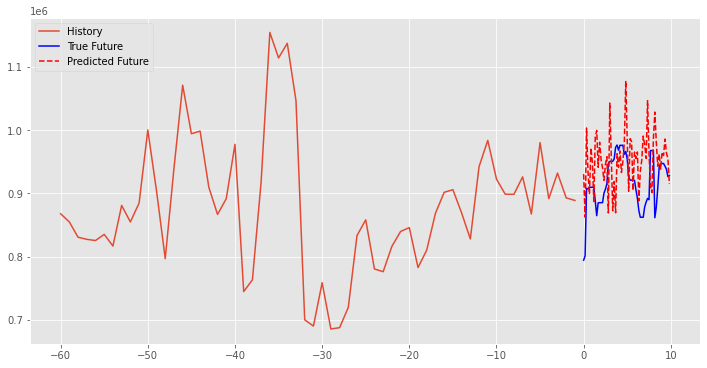

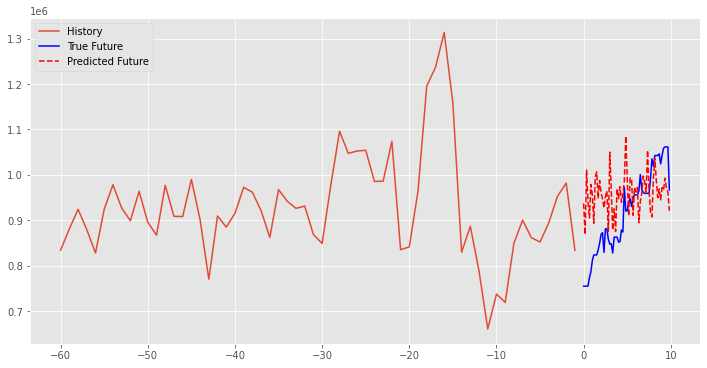

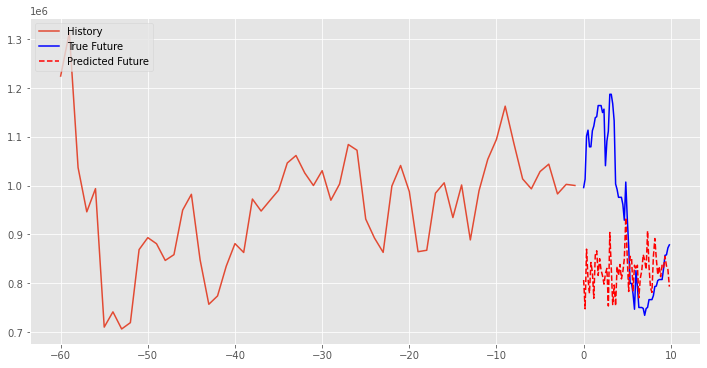

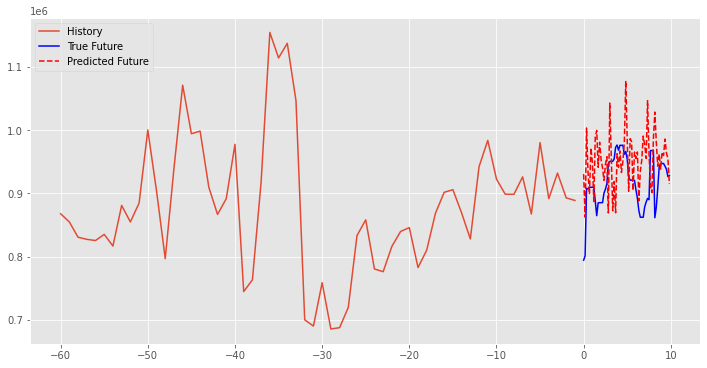

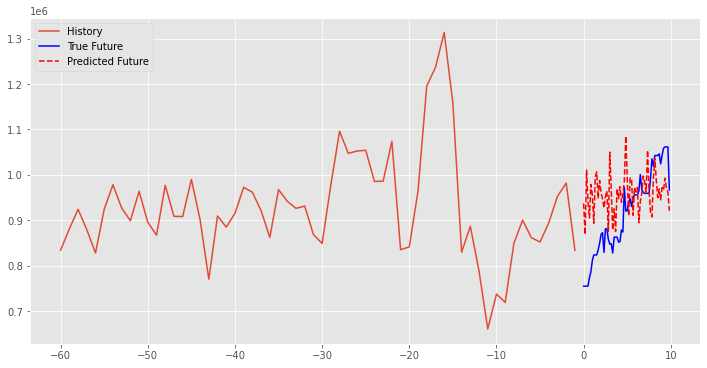

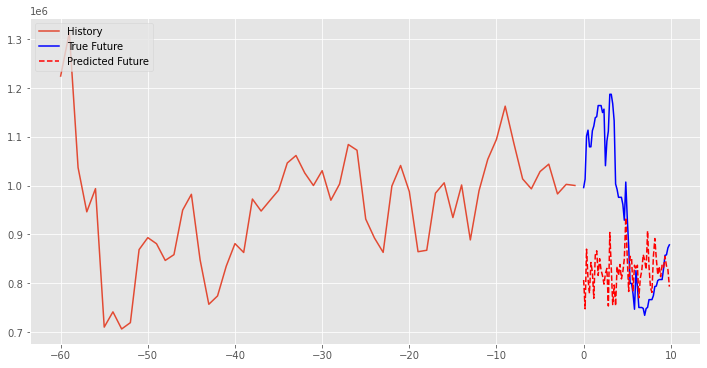

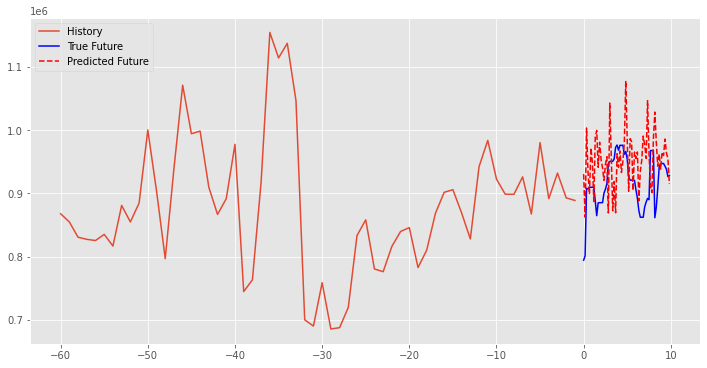

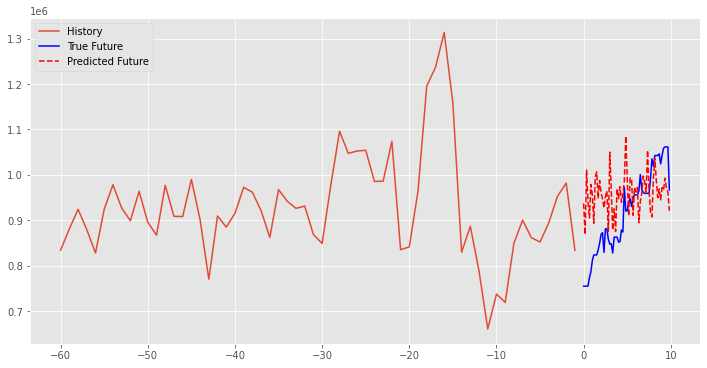

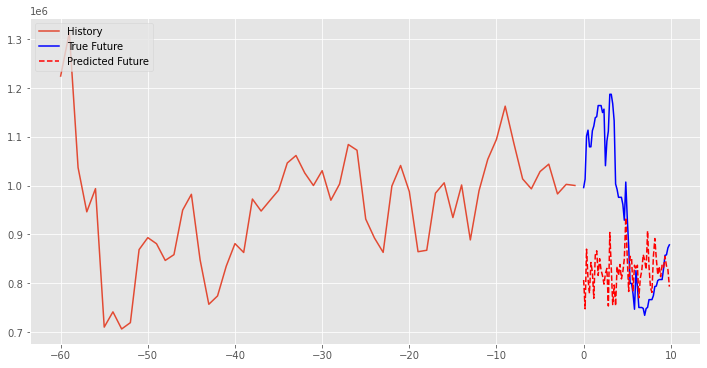

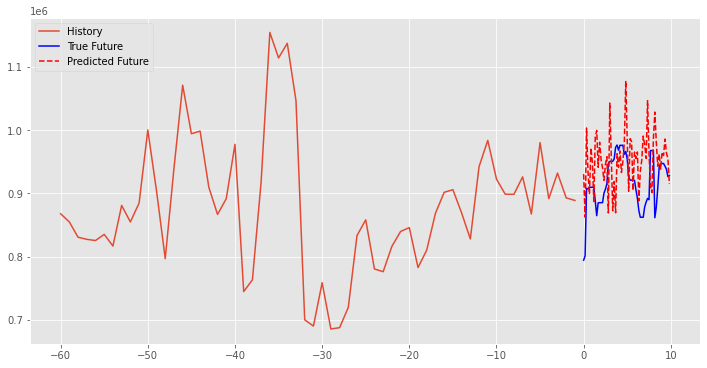

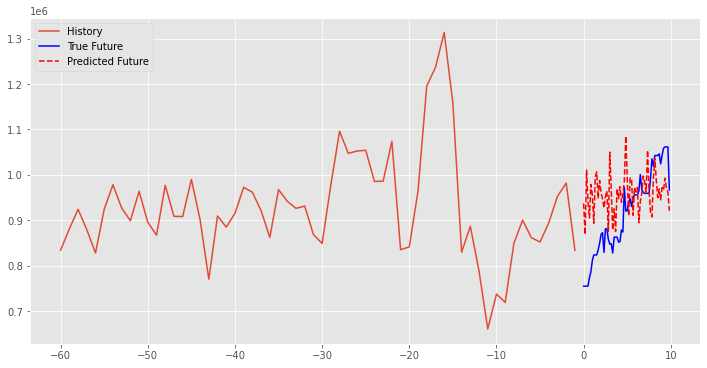

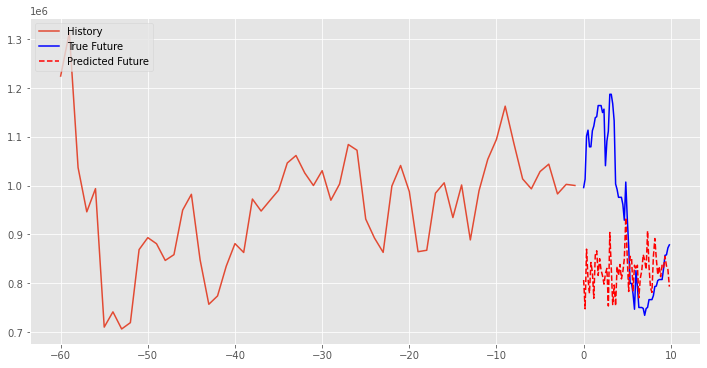

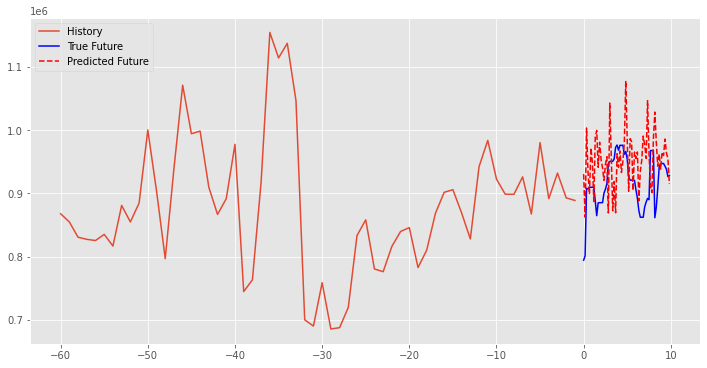

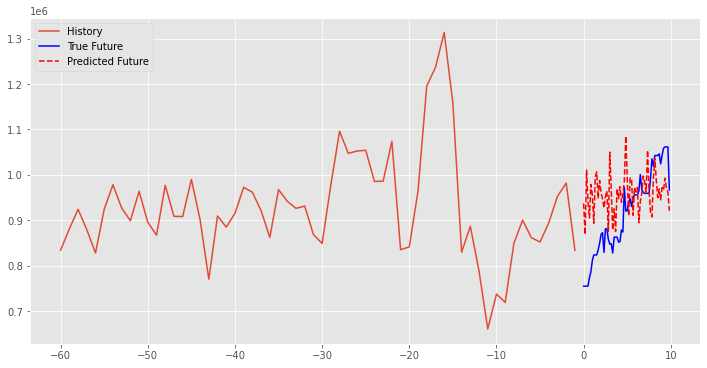

In [0]:
# print(X_val[:1])

for x, y in val_data_slices.take(20):
    multi_step_plot(x[0], y[0], lstm.predict(x)[0], X_data_mean, X_data_std)

Using the chart to show how the performance work. It shows the forecast is likely around the real future data, which means the performance of LSTM is reasonable.

# If only look into the prediction and true future - as in testing data

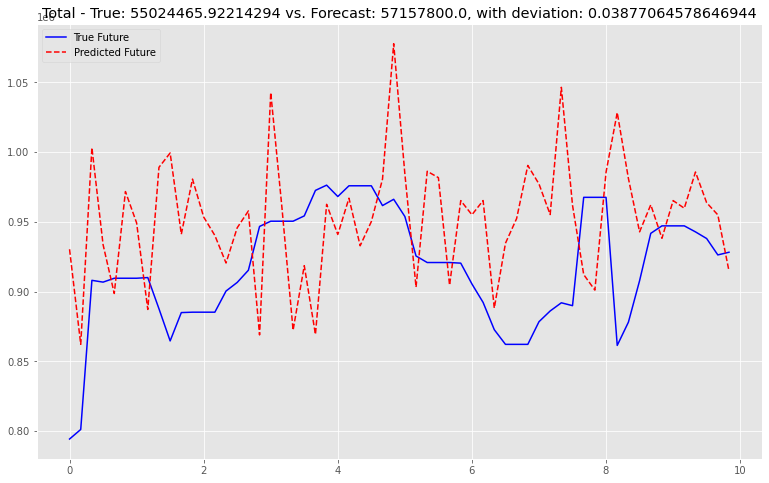

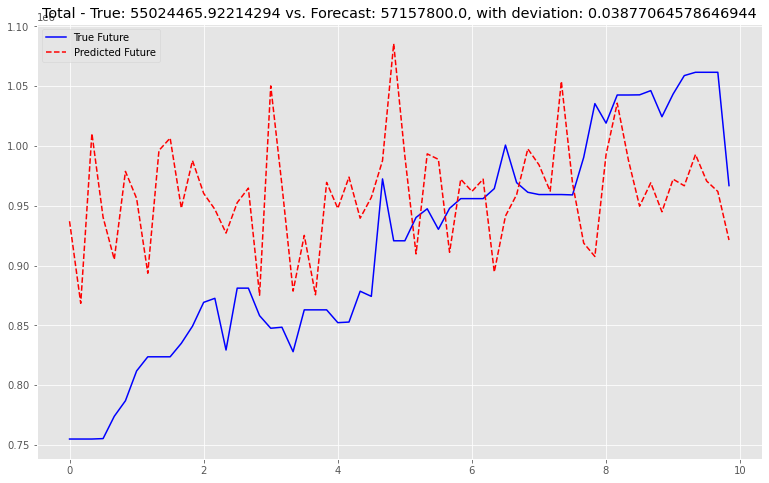

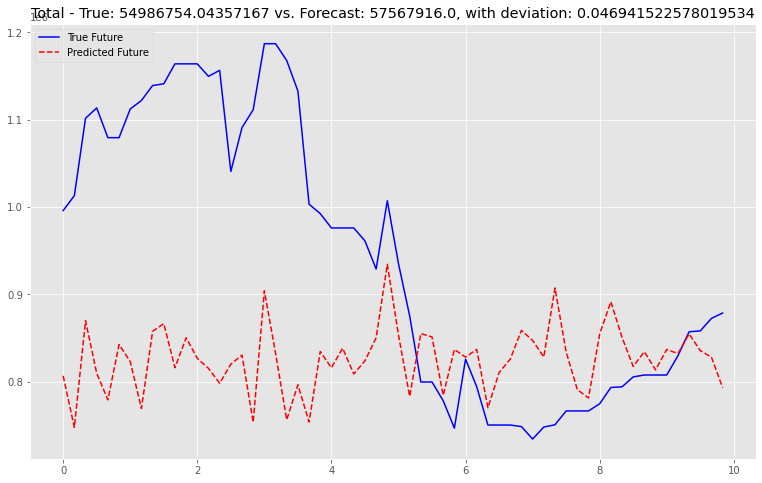

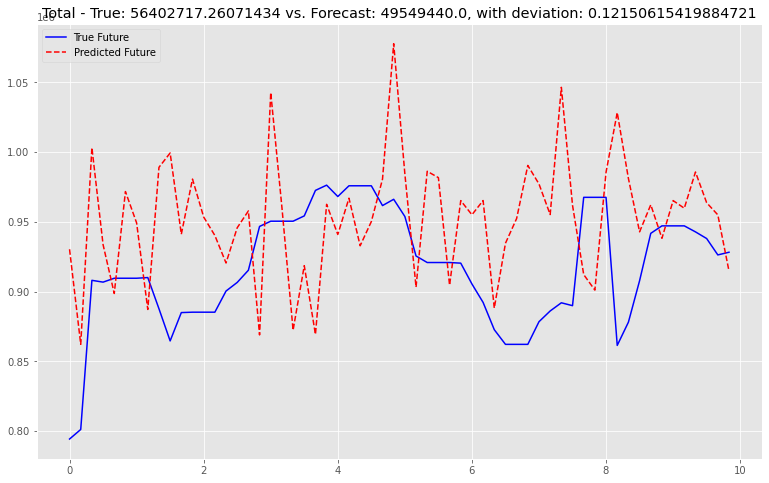

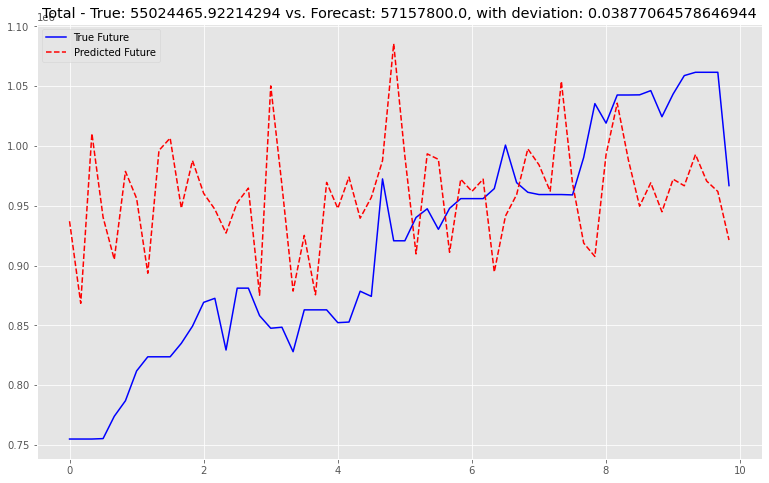

Overall accuracy mean: 0.9339574386523521 (i.e. inaccuracy mean: 0.06604256134764781), Deviation: 0.03646670941507 for sampled 10 forecasting.


In [0]:
deviations = list()
plot_limit = 5
for x, y in val_data_slices.take(10):
    true_future = y[0]
    predict_future = lstm.predict(x)[0]
    mean, std = X_data_mean, X_data_std    
    future_num = np.arange(len(true_future))/STEP   
    
    if plot_limit > 0: 
        plt.plot(future_num, np.array(true_future), 'b-', label='True Future')
        plt.plot(future_num, np.array(predict_future), 'r--', label='Predicted Future')
        plt.legend(loc='upper left')
        plot_limit = plot_limit - 1
        plt.title(F"Total - True: {t_sum} vs. Forecast: {p_sum}, with deviation: {dev}")
        plt.show()
    
    
    t_sum = np.sum(true_future)
    p_sum = np.sum(predict_future)
    
    dev = np.absolute((p_sum - t_sum)/t_sum)
    deviations.append(dev)  
    
    

#     plt.plot(num_in, np.array(invert_history[:, hist_pos]), label='History')
dev_mean = np.mean(deviations)
dev_std = np.std(deviations)
print(F"Overall accuracy mean: { 1 - dev_mean} (i.e. inaccuracy mean: {dev_mean}), Deviation: {dev_std} for sampled {len(deviations)} forecasting.")

By analysis of the sale total for 60-day forecast against 60-day real data to evaluate the model performance. As presented above, the accuracy is around 93.4% with the deviation of 3.65%, which we consider the performance is good.

#  Result

By above two aspects of the analysis 60 days forecasting, we think the model works well regarding time series forecast of the sale data. We also found the result tend to be worse if forecasting longer future steps.  

**Reference**: https://www.tensorflow.org/tutorials/structured_data/time_series